<a href="https://colab.research.google.com/github/sphynxlee/LipNet/blob/main/LipNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install and Import Dependencies

In [1]:
!pip list

Package                           Version
--------------------------------- ------------
absl-py                           2.1.0
aiobotocore                       2.7.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.12
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.1.4
anaconda-navigator                2.5.4
anaconda-project                  0.11.1
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.3
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid                           2.14.2
astropy                           5.3.4
asttokens                         2.0.5
astunparse               

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import keras

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

In [7]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [8]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
# char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# num_to_char = tf.keras.layers.StringLookup(
#     vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
# )
char_to_num = keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [13]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [14]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [15]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    # file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [16]:
test_path = '.\\data\\s1\\bbal6n.mpg'
# test_path = './data/s1/bbal6n.mpg'

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]
# tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

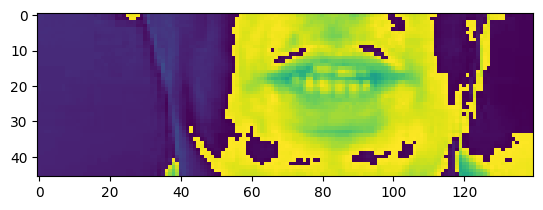

In [19]:
plt.imshow(frames[40])

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [22]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [23]:
from matplotlib import pyplot as plt

In [54]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [25]:
len(test)

50

In [26]:
frames, alignments = data.as_numpy_iterator().next()

In [27]:
len(frames)

2

In [28]:
sample = data.as_numpy_iterator()

In [29]:
val = sample.next(); val[0]

array([[[[[ 1.3226067 ],
          [ 1.3226067 ],
          [ 1.4393072 ],
          ...,
          [ 9.0637455 ],
          [ 9.725049  ],
          [ 9.763949  ]],

         [[ 1.3226067 ],
          [ 1.3226067 ],
          [ 1.4393072 ],
          ...,
          [ 9.180446  ],
          [ 9.608348  ],
          [ 9.686149  ]],

         [[ 1.2448063 ],
          [ 1.2448063 ],
          [ 1.2448063 ],
          ...,
          [ 9.802849  ],
          [ 9.91955   ],
          [ 9.91955   ]],

         ...,

         [[ 0.89470446],
          [ 0.89470446],
          [ 0.89470446],
          ...,
          [ 9.802849  ],
          [ 9.725049  ],
          [ 9.725049  ]],

         [[ 0.89470446],
          [ 0.89470446],
          [ 0.89470446],
          ...,
          [ 9.647248  ],
          [ 9.647248  ],
          [ 9.647248  ]],

         [[ 0.89470446],
          [ 0.89470446],
          [ 0.89470446],
          ...,
          [ 9.647248  ],
          [ 9.647248  ],
          

In [30]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.919549942016602]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.919549942016602]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.919549942016602]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.919549942016602]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.919549942016602]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.919549942016602]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.919549942016602]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

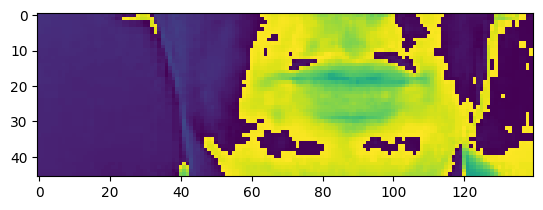

In [31]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [32]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set green with x three soon'>

# 3. Design the Deep Neural Network

In [33]:
from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

from keras.models import Sequential
from keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [34]:
from keras.layers import LSTM, Bidirectional
from keras.initializers import Orthogonal

In [35]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [36]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))


model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, return_sequences=True)))

# # model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Bidirectional(LSTM(128, kernel_initializer=Orthogonal(), return_sequences=True)))
# model.add(Dropout(.5))

# # model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
# model.add(Bidirectional(LSTM(128, kernel_initializer=Orthogonal(), return_sequences=True)))
# model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,077,684 (30.81 MB)

 Trainable params: 8,077,684 (30.81 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
5*17*75

6375

In [39]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [40]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'ddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd'>

In [41]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'ddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddd'>

In [42]:
model.input_shape

(None, 75, 46, 140, 1)

In [43]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [44]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [45]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    # loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [46]:
class ProduceExample(keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

# class ProduceExample(tf.keras.callbacks.Callback):
#     def __init__(self, dataset) -> None:
#         self.dataset = dataset.as_numpy_iterator()

#     def on_epoch_end(self, epoch, logs=None) -> None:
#         data = self.dataset.next()
#         yhat = self.model.predict(data[0])
#         decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
#         for x in range(len(yhat)):
#             print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
#             print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
#             print('~'*100)

In [47]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [48]:
# checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)


# Adjust the file path to end with '.weights.h5'
checkpoint_path = os.path.join('models', 'checkpoint.weights.h5')

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='loss',
    save_weights_only=True
)


In [49]:
schedule_callback = LearningRateScheduler(scheduler)

In [50]:
example_callback = ProduceExample(test)

In [52]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/time_distributed_1/Reshape_43 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\lhdto\AppData\Local\Temp\ipykernel_17328\3536403359.py", line 1, in <module>

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 329, in fit

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 122, in one_step_on_iterator

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 110, in one_step_on_data

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 57, in train_step

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 825, in __call__

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\sequential.py", line 202, in call

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 195, in call

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\function.py", line 151, in _run_through_graph

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 579, in call

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 825, in __call__

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 108, in call

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\time_distributed.py", line 102, in step_function

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py", line 54, in call

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\numpy.py", line 4522, in reshape

  File "c:\Users\lhdto\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1618, in reshape

Only one input size may be -1, not both 0 and 1
	 [[{{node sequential_1/time_distributed_1/Reshape_43}}]] [Op:__inference_one_step_on_iterator_27512]

# 5. Make a Prediction

In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=28aca149-41af-49fd-b783-ca9b4b4cc840
To: c:\haidun.li\NSCC\LipNet\checkpoints.zip
100%|██████████| 94.5M/94.5M [00:05<00:00, 17.1MB/s]


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [ ]:
model.load_weights('./models/checkpoint')

ValueError: File format not supported: filepath=./models/checkpoint. Keras 3 only supports V3 `.keras` and `.weights.h5` files, or legacy V1/V2 `.h5` files.

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
# decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()
decoded = keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
# decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
decoded = keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]